In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGenerator.InputDist.RAW

num_decomps=2
num_subsets=5
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 2

### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(10, 11)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/spn/data/mnist")

Extracting /home/jos/spn/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/jos/spn/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/jos/spn/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/jos/spn/data/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    plt.imshow(img.reshape((28, 28)), interpolation='none')
    plt.show()

### Process data

In [6]:
def process_set(data):
    threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 1.0, interp='nearest') > threshold).astype(dtype=int))
    images=np.stack(resized)
    return images

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/jos/.local/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


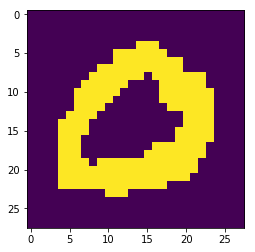

In [8]:
show_mnist(train_images[19])

In [9]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 28, 28)


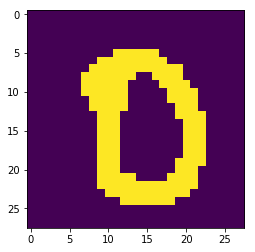

(6179, 28, 28)


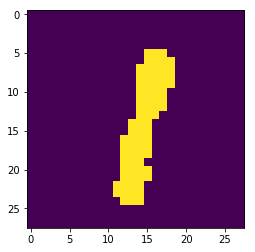

(980, 28, 28)


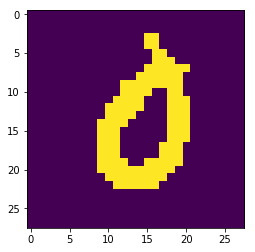

(1135, 28, 28)


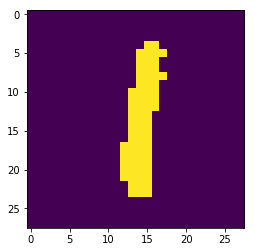

In [10]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

# Generate SPN structure

In [11]:
ivs = spn.DynamicIVs(num_vars=28, num_vals=2, max_steps=28)
dense_gen = spn.DenseSPNGenerator(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                  input_dist=input_dist, 
                                  num_input_mixtures=num_input_mixtures)
dense0 = dense_gen.generate(ivs)
dense1 = dense_gen.generate(ivs)

interface0 = spn.DynamicInterface(name="interface0")
interface1 = spn.DynamicInterface(name="interface1")

interface_mixture0 = spn.Sum(interface0, interface1, name="intf_mixture0", interface_head=True)
interface_mixture1 = spn.Sum(interface0, interface1, name="intf_mixture1", interface_head=True)

template_root0 = spn.Sum(dense0, dense1)
template_root1 = spn.Sum(dense0, dense1)

prod0 = spn.Product(template_root0, interface_mixture0, name="Prod0")
prod1 = spn.Product(template_root1, interface_mixture1, name="Prod1")

interface0.set_source(prod0)
interface1.set_source(prod1)

root = spn.Sum(prod0, prod1)

spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

1444


# Add Learning Ops

In [12]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood = learning.value.values[root].read(13)
avg_train_likelihood = tf.reduce_mean(train_likelihood)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:277: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:281: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use the `axis` argument instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/graph/sum.py:299: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


# Run Training

In [13]:
sess=None

In [14]:
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_set = np.transpose(train_set, (1, 0, 2))
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()
sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=1
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0
while abs(prev_likelihood - likelihood)>0.1:
    prev_likelihood=likelihood
    likelihoods = []
    for batch in range(num_batches):
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
        print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
        print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _, = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={ivs: train_set[:, start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
        print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
        # Update weights
        sess.run(update_spn)
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
    sess.run(reset_accumulators)

EPOCH 0 BATCH 0 SAMPLES 0 28
Smoothing:  100.0
Avg likelihood (this batch data on previous weights): -272.20273
Avg likelihood: -272.2027282714844
EPOCH 1 BATCH 0 SAMPLES 0 28
Smoothing:  81.87308
Avg likelihood (this batch data on previous weights): -248.23367
Avg likelihood: -248.23367309570312
EPOCH 2 BATCH 0 SAMPLES 0 28
Smoothing:  67.032005
Avg likelihood (this batch data on previous weights): -237.10757
Avg likelihood: -237.10757446289062
EPOCH 3 BATCH 0 SAMPLES 0 28
Smoothing:  54.881165
Avg likelihood (this batch data on previous weights): -230.53625
Avg likelihood: -230.5362548828125
EPOCH 4 BATCH 0 SAMPLES 0 28
Smoothing:  44.932896
Avg likelihood (this batch data on previous weights): -223.359
Avg likelihood: -223.35899353027344
EPOCH 5 BATCH 0 SAMPLES 0 28
Smoothing:  36.787945
Avg likelihood (this batch data on previous weights): -216.19067
Avg likelihood: -216.190673828125
EPOCH 6 BATCH 0 SAMPLES 0 28
Smoothing:  30.119421
Avg likelihood (this batch data on previous weig

# Generate Testing Ops

In [16]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [17]:
mpe_ivs, mpe_latent = mpe_state_gen.get_state(root, ivs, latent)

# Run Testing

### MPE of the whole network

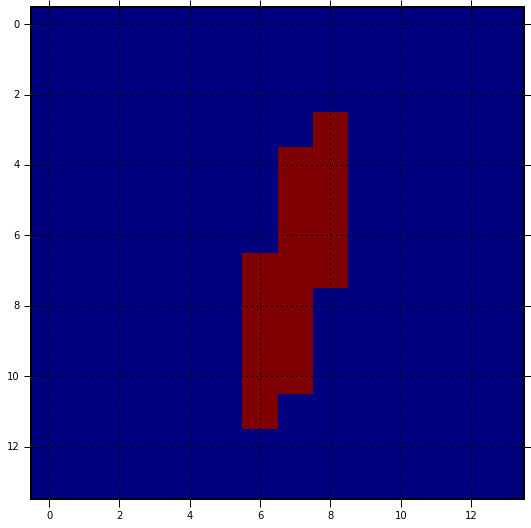

[[1]]


In [21]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[-1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 0

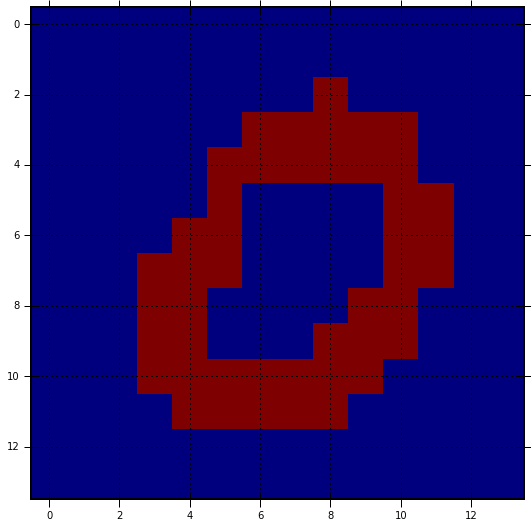

[[0]]


In [23]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[0]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### MPE for 1

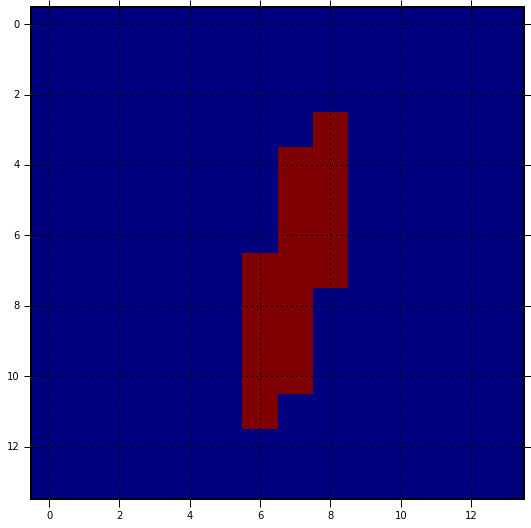

[[1]]


In [26]:
mpe_ivs_val, mpe_latent_val = sess.run([mpe_ivs, mpe_latent], feed_dict={ivs: np.ones((1, 14*14), dtype=int) * -1,
                                                                       latent: [[1]]})
show_mnist(mpe_ivs_val)
print(mpe_latent_val)

### Classification of Training Data

In [36]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: train_set, 
                                                   latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

0.99630043878516739

### Classification of Test Data

In [42]:
test_set = np.concatenate([test_images_0, test_images_1], 0)
test_labels = np.concatenate([np.ones((test_images_0.shape[0]))*0, 
                               np.ones((test_images_1.shape[0]))*1])
test_labels=np.reshape(test_labels, (-1, 1))

In [43]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={ivs: test_set, 
                                                   latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.99763593380614657